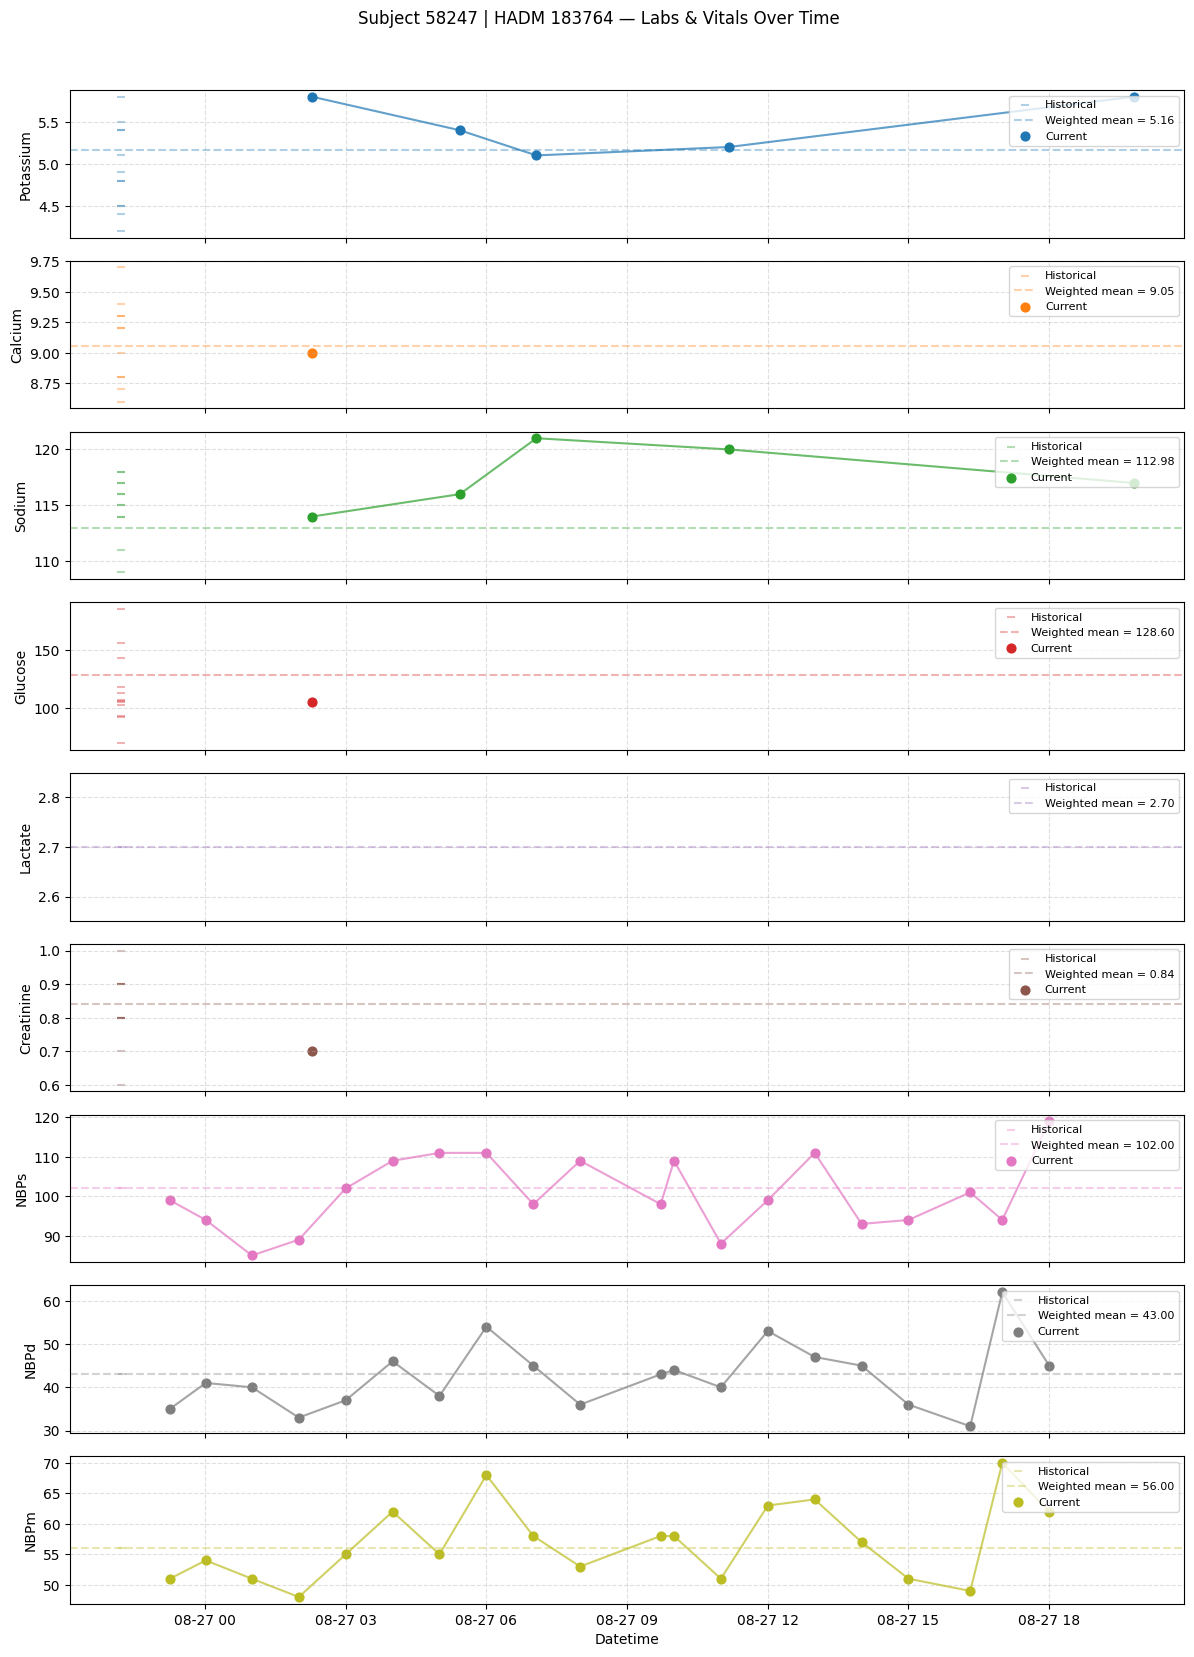

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors


def time_weighted_mean(times, values, decay=3.0):
    if len(times) == 0:
        return np.nan

    t = (times.max() - times).dt.total_seconds().to_numpy()

    if t.max() == 0:
        weights = np.ones_like(t)
    else:
        weights = np.exp(-decay * t / t.max())

    return np.average(values, weights=weights)


def plot_merged_lab_vital_overlay(
    df_hist,
    df_curr,
    subject_id,
    hadm_id,
    hist_frac=0.05,
    jitter_frac=0.02,
    decay=3.0,
):
    # -----------------------------------------------------------
    # FIXED explicit list of variables (prevents KeyErrors)
    # -----------------------------------------------------------
    lab_cols = [
        "Potassium","Calcium","Sodium","Glucose",
        "Lactate","Creatinine"
    ]

    vital_cols = [
        "NBPs","NBPd","NBPm"
    ]

    # Only keep columns that actually exist
    lab_cols = [c for c in lab_cols if c in df_curr.columns]
    vital_cols = [c for c in vital_cols if c in df_curr.columns]

    # -----------------------------------------------------------
    # Filter encounter
    # -----------------------------------------------------------
    curr = df_curr[(df_curr["SUBJECT_ID"] == subject_id) &
                   (df_curr["HADM_ID"] == hadm_id)]

    if curr.empty:
        print("No current labs/vitals for this subject/HADM.")
        return

    start_time = curr["CHARTTIME"].min()
    hist = df_hist[(df_hist["SUBJECT_ID"] == subject_id) &
                   (df_hist["HADM_ID"] == hadm_id) &
                   (df_hist["CHARTTIME"] < start_time)].copy()

    # -----------------------------------------------------------
    # Compute jitter times for history
    # -----------------------------------------------------------
    tmin, tmax = curr["CHARTTIME"].min(), curr["CHARTTIME"].max()
    total_range = (tmax - tmin).total_seconds()

    hist_start_time = tmin - pd.Timedelta(seconds=total_range * hist_frac)

    if len(hist) > 0:
        offsets = np.linspace(-1, 0, len(hist)) * total_range * hist_frac * jitter_frac
        hist["plot_time"] = [
            hist_start_time + pd.Timedelta(seconds=float(o))
            for o in offsets
        ]
    else:
        hist["plot_time"] = pd.NaT

    # -----------------------------------------------------------
    # Determine variables to plot
    # -----------------------------------------------------------
    labs_present = [c for c in lab_cols
                    if curr[c].notna().any() or hist[c].notna().any()]
    vitals_present = [c for c in vital_cols
                      if curr[c].notna().any() or hist[c].notna().any()]

    all_vars = labs_present + vitals_present

    if len(all_vars) == 0:
        print("No lab or vital values to plot.")
        return

    # -----------------------------------------------------------
    # Plot
    # -----------------------------------------------------------
    fig, axs = plt.subplots(len(all_vars), 1,
                            figsize=(12, 1.8 * len(all_vars)),
                            sharex=True)

    if len(all_vars) == 1:
        axs = [axs]

    colors = list(plt.cm.tab10.colors)

    for i, (ax, col) in enumerate(zip(axs, all_vars)):
        base_color = colors[i % len(colors)]
        hist_color = mcolors.to_rgba(base_color, alpha=0.35)

        sub_curr = curr[curr[col].notna()]
        sub_hist = hist[hist[col].notna()]

        # -- history
        if not sub_hist.empty:
            ax.scatter(sub_hist["plot_time"], sub_hist[col],
                       marker="_", s=40, color=hist_color, label="Historical")

            hmean = time_weighted_mean(sub_hist["CHARTTIME"], sub_hist[col], decay=decay)
            ax.axhline(hmean, color=hist_color, linestyle="--",
                       label=f"Weighted mean = {hmean:.2f}")

        # -- current admission
        if not sub_curr.empty:
            sc = sub_curr.sort_values("CHARTTIME")
            ax.scatter(sc["CHARTTIME"], sc[col],
                       color=base_color, s=40, label="Current")
            if len(sc) > 1:
                ax.plot(sc["CHARTTIME"], sc[col], color=base_color, alpha=0.7)

        ax.set_ylabel(col)
        ax.grid(True, linestyle="--", alpha=0.4)
        ax.legend(loc="upper right", fontsize=8)

    axs[-1].set_xlabel("Datetime")
    fig.suptitle(f"Subject {subject_id} | HADM {hadm_id} — Labs & Vitals Over Time", y=1.02)

    plt.tight_layout()
    plt.show()


############################
df_hist = pd.read_csv(
    "./mimic_lab_vital_waveform_history.csv",
    parse_dates=["CHARTTIME"]
)

df_curr = pd.read_csv(
    "./mimic_lab_vital_waveform_overlap.csv",
    parse_dates=["CHARTTIME"]
)

plot_merged_lab_vital_overlay(
    df_hist,
    df_curr,
    subject_id=58247,
    hadm_id=183764
)



2694


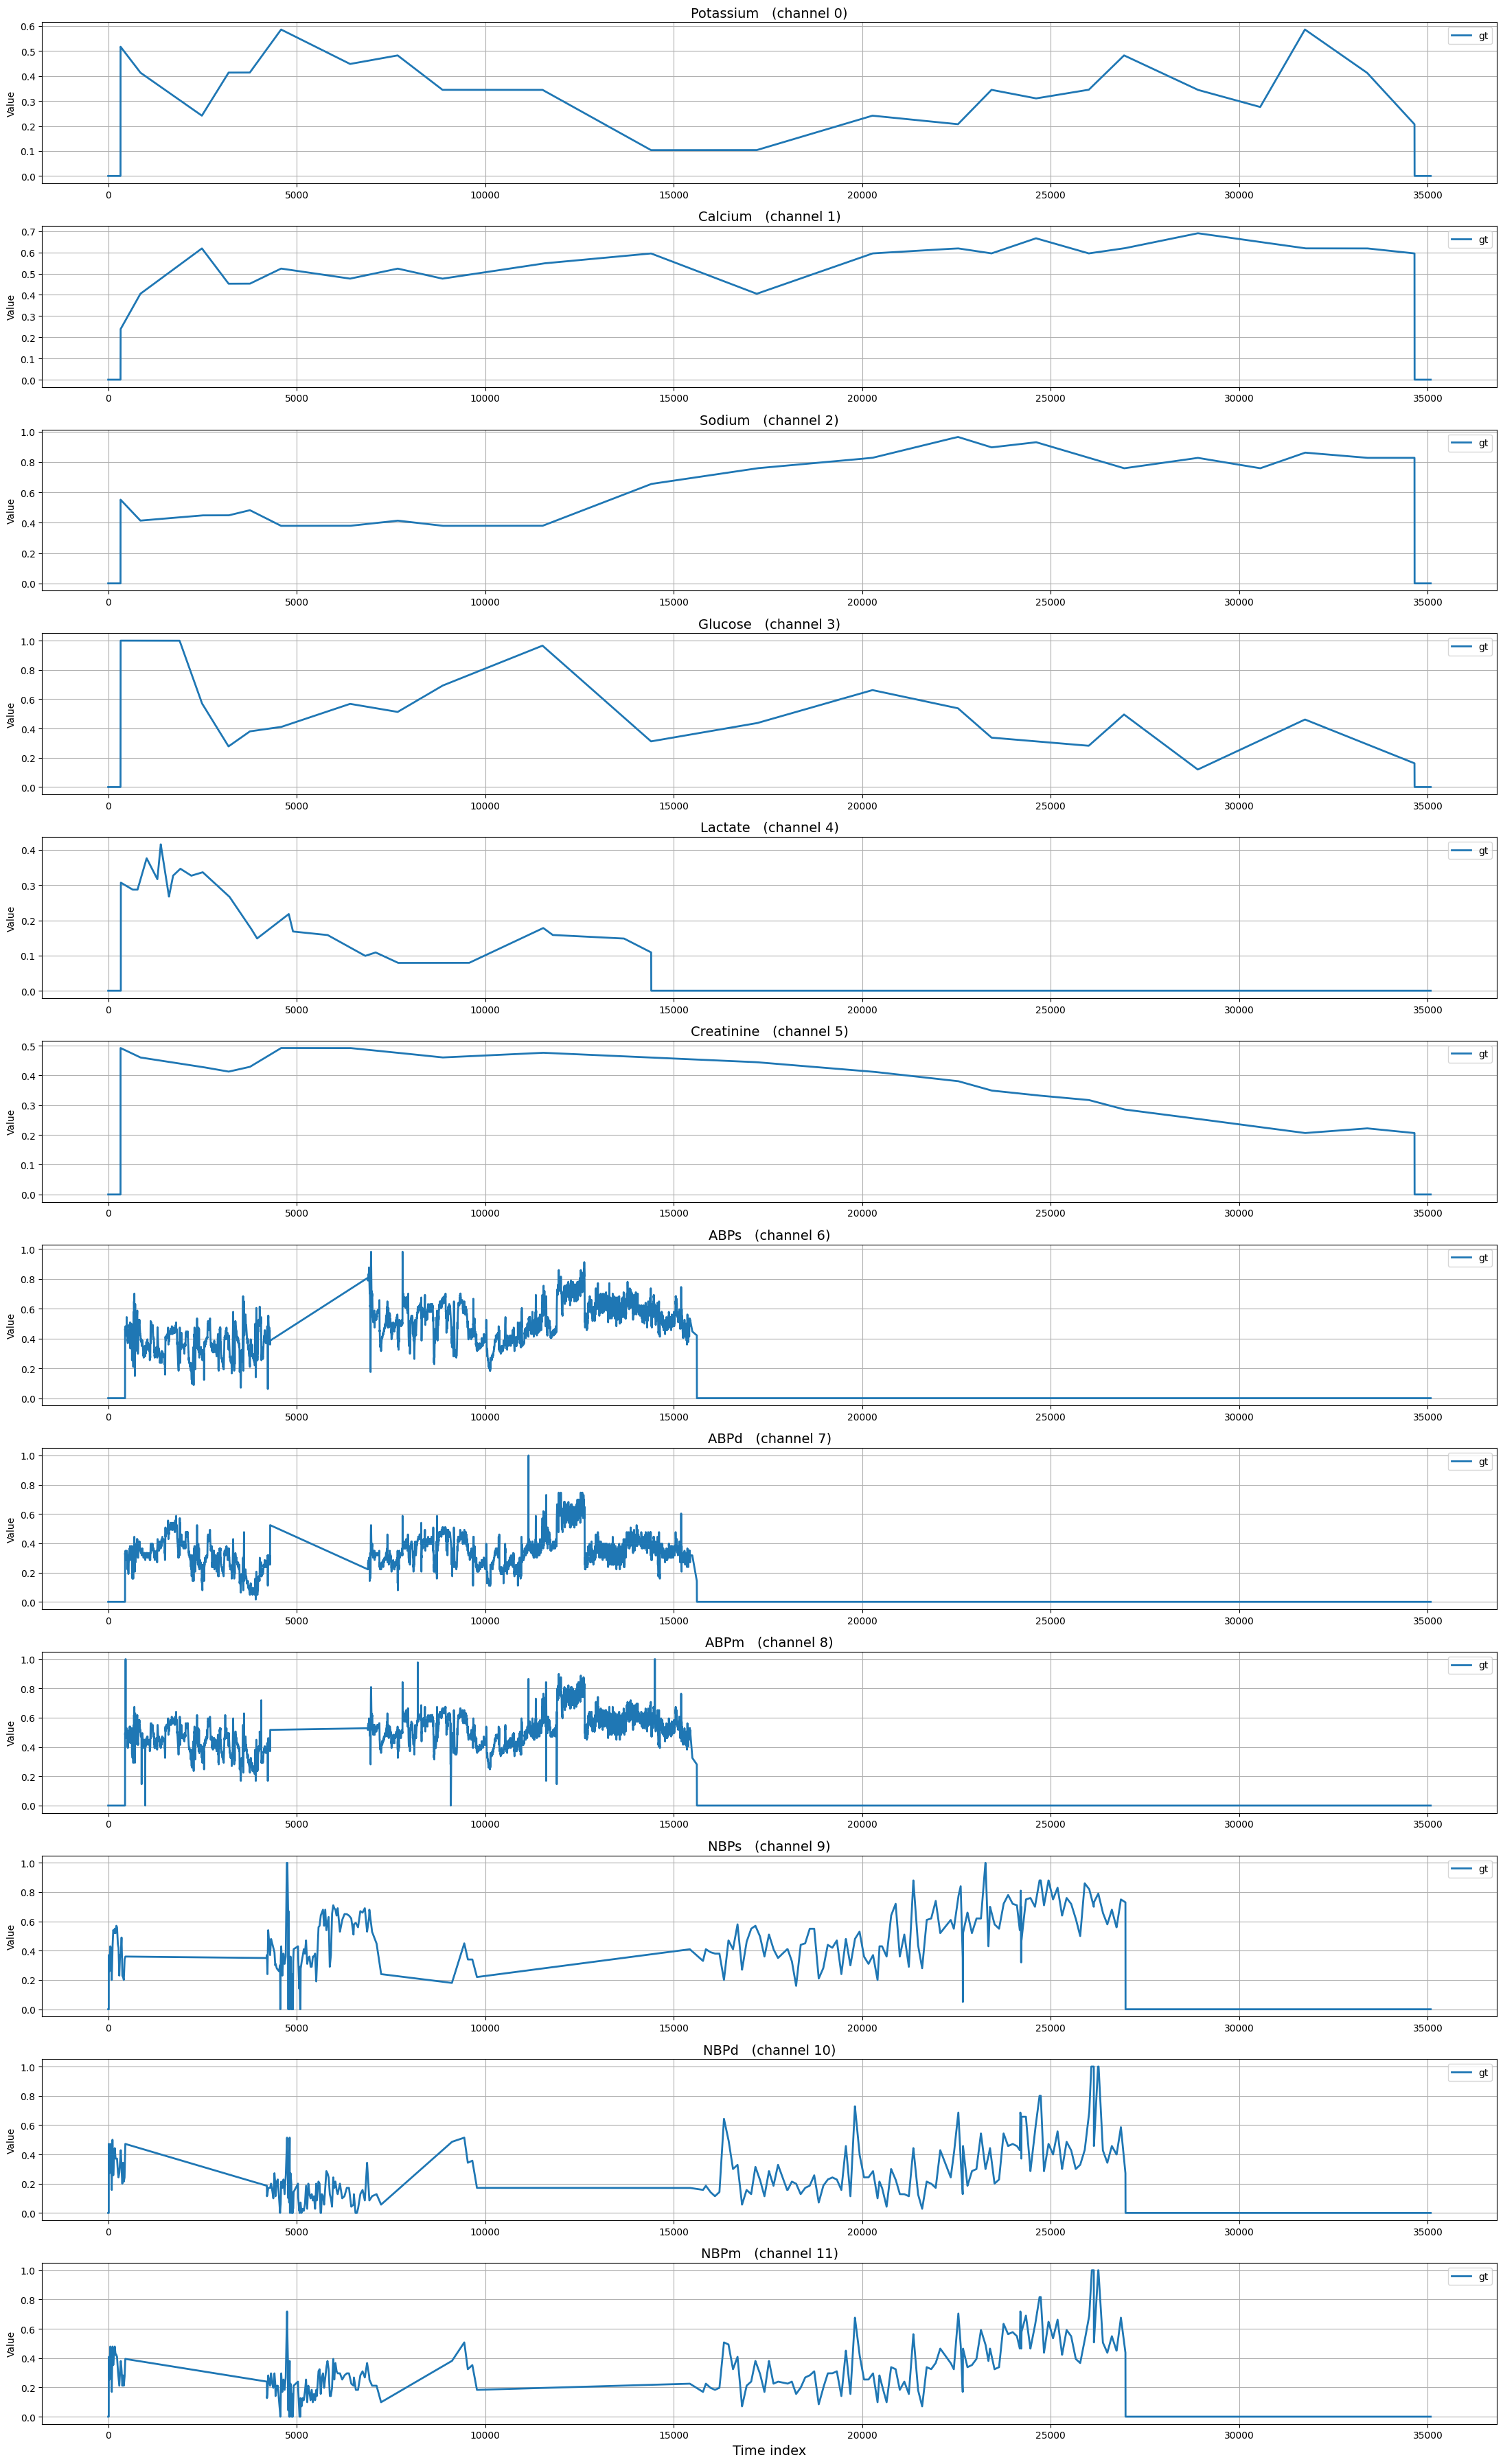

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# ---------------------------------------------------------------------
# Configuration
# ---------------------------------------------------------------------
DATA_DIR = "/opt/localdata100tb/UNIPHY_Plus/dataset/EST/MIMIC3_SPO2_I_40hz_v3_lab_vital"
print(len([f for f in os.listdir(DATA_DIR) if f.endswith(".npz")]))
FILE_NAME = sorted([f for f in os.listdir(DATA_DIR) if f.endswith(".npz")])[5]
SEG_IDX = 375  # choose 30s segment to visualize

# ---------------------------------------------------------------------
# Load npz
# ---------------------------------------------------------------------
path = os.path.join(DATA_DIR, FILE_NAME)
data = np.load(path)

time_ms = data["time"]               # window start timestamps (ms)
pleth = data["PLETH40"]
ii120 = data["II120"]
ii500 = data["II500"]

# ---------------------------------------------------------------------
# Multi-channel EHR Plot along dim 0
# ---------------------------------------------------------------------

ehr_mask  = data["ehr_mask"]   # (T, C)
ehr_gt    = data["ehr_gt"]     # (T, C)
ehr_trend = data["ehr_trend"]  # (T, C)

T, C = ehr_gt.shape
time_axis = np.arange(T)

# Optional: give readable lab names
target_names = [
    "Potassium", "Calcium", "Sodium",
    "Glucose", "Lactate", "Creatinine",
        "ABPs", "ABPd", "ABPm",
    "NBPs", "NBPd", "NBPm",
]
if len(target_names) != C:
    target_names = [f"lab_{i}" for i in range(C)]

plt.figure(figsize=(22, 3*C))

for c in range(C):
    plt.subplot(C, 1, c+1)

    # Ground Truth
    plt.plot(time_axis, ehr_gt[:, c], label="gt", linewidth=2)

    # Trend
    #plt.plot(time_axis, ehr_trend[:, c], "--", linewidth=1.5, label="trend")

    # Mask (0/1/2)
    #plt.step(time_axis, ehr_mask[:, c], where="mid", label="mask", alpha=0.7)

    plt.title(f"{target_names[c]}   (channel {c})", fontsize=14)
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend(loc="upper right")

plt.xlabel("Time index", fontsize=14)
plt.tight_layout()
plt.show()
